# Boston Housing Dataset

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load datset

Load the dataset into a pandas DataFrame

In [2]:
boston = load_boston()

df = pd.DataFrame(boston['data'], columns = boston['feature_names'])
df['price'] = boston['target']

In [3]:
# Rows, columns
df.shape

(506, 14)

In [4]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
# View the first few rows of the dataframe
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
# Check for nulls
np.sum(df.isnull(), axis=0)

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
price      0
dtype: int64

## First pass with naive Linear Regression

In [7]:
from sklearn.model_selection import train_test_split
 
# Split the data into X and y variables
X, y = df[df.columns.difference(['price'])], df.price
 
# Split into training and testing datasets
# The random_state=0 kwarg ensures that the split is performed in a consistent manner between runs
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))    

In [9]:
model = LinearRegression() 
# Fit training set
model.fit(X_train, y_train)
# Predict on test set
y_pred = model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [10]:
def plot_results(y_test, y_pred):
    # Scatter plot
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].scatter(y_test, y_pred)
    ax[0].set_xlabel('true price')
    ax[0].set_ylabel('predicted price')
    ax[0].plot([0,50],[0,50], 'k--')
    fig.suptitle('Boston house price prediction with linear regression model')

    # Distribution of errors
    ax[1].hist(y_pred - y_test)
    ax[1].set_xlabel('difference in true and predicted price')
    plt.show()

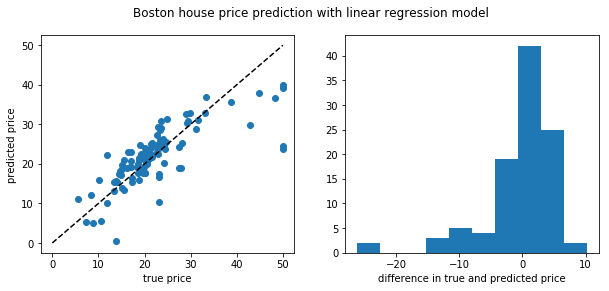

In [11]:
plot_results(y_test, y_pred)

In [12]:
rmse(y_test, y_pred)

5.783658787280867

Without any feature engineering or modelling work the predictions and reasonably good - we will continue investigating the linear model.

## Feature Engineering

First check the relationship between variables and the target

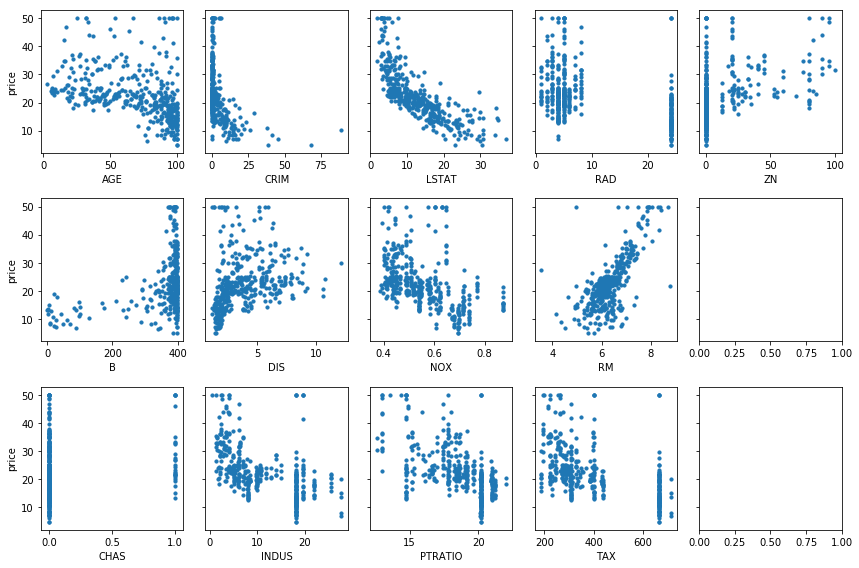

In [13]:
fig, ax = plt.subplots(3,5, figsize=(12,8), sharey=True)
for i, colname in enumerate(X_train.columns):
    row, col = i % 3, i // 3
    ax[row,col].scatter(X_train[colname], y_train, s=10)
    ax[row,col].set_xlabel(colname)
    if col == 0:
        ax[row,col].set_ylabel('price')
plt.tight_layout()

Perform the following data transformations 
1. One Hot Encode categorical variables (`CHAS`)
2. Standard Scale the remaining variables
3. Add order-2 cross terms 

In [14]:
from sklearn.preprocessing import StandardScaler
from itertools import combinations

In [15]:
class Boston:
    
    def __init__(self, X_train):
        self.cat_cols = ['CHAS']
        self.cts_cols = X_train.columns.difference(['CHAS'])
        self.sc = StandardScaler(with_mean=True, with_std=True)
        self.ohe_cols = []
        
    def _fit_ohe_cat(self, X_train):
        all_columns = []
        for c in self.cat_cols:
            all_columns.append(pd.get_dummies(X_train[c].astype(int), prefix=c).columns)
        self.ohe_cols = [ci for c in all_columns for ci in c]
    
    def _fit_scale_cts(self, X_train):
        self.sc.fit(X_train[self.cts_cols])
        
    def fit(self, X_train):
        self._fit_ohe_cat(X_train)
        self._fit_scale_cts(X_train)
        
    def _transform_ohe_cat(self, X):
        x = X[self.cat_cols].astype(int)
        ohe_x = pd.get_dummies(x, columns=self.cat_cols)[self.ohe_cols]
        # check all values have appeared
        col_diff = set(self.ohe_cols) - set(ohe_x.columns)
        for c in col_diff:
            ohe_x[c] = 0.
        return ohe_x
    
    def _transform_scale_cts(self, X):
        sc_x = self.sc.transform(X[self.cts_cols])
        return sc_x # pd.DataFrame(sc_x, columns=self.cts_cols)
    
    def polynomial(self, X, n):
        Xcols = list(X.columns)
        # cross terms
        for cols in combinations(Xcols, n):
            X['-'.join(cols)] = np.prod([X[c] for c in cols], axis=0)
        
        return X
        
    def transform(self, X):
        cat_x = self._transform_ohe_cat(X)
        cts_x = self._transform_scale_cts(X)
        x = np.concatenate([cat_x, cts_x], axis=1)
        x = pd.DataFrame(x, columns=self.ohe_cols + list(self.cts_cols))
        return self.polynomial(x, 2)
        
    

In [16]:
data = Boston(X_train)
data.fit(X_train)

In [17]:
X_train_tr = data.transform(X_train)
X_test_tr = data.transform(X_test)

In [18]:
X_train_tr.head()

,CHAS_0,CHAS_1,AGE,B,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,...,PTRATIO-RAD,PTRATIO-RM,PTRATIO-TAX,PTRATIO-ZN,RAD-RM,RAD-TAX,RAD-ZN,RM-TAX,RM-ZN,TAX-ZN
0,0.0,1.0,0.693669,0.371691,-0.369848,-0.437218,-0.704925,-0.411000,-0.424879,-0.484638,...,0.078629,-0.453465,0.272200,0.242129,-0.151807,0.091124,0.081058,-0.525529,-0.467472,0.280608
1,1.0,0.0,-1.835528,0.205012,-0.394393,0.730055,-0.044878,-0.387681,-1.241859,0.336491,...,-0.210189,-0.165278,-0.192936,-0.168114,0.306815,0.358158,0.312079,0.281632,0.245398,0.286463
2,1.0,0.0,-0.524621,0.366609,-0.399992,1.234769,-0.886760,-0.181919,-1.111490,-0.849584,...,0.334265,-0.728815,0.512025,-0.655172,-0.337517,0.237120,-0.303412,-0.517006,0.661546,-0.464765
3,1.0,0.0,-0.086464,0.415732,-0.403071,0.861527,-0.465819,-0.037886,-0.277127,-1.488240,...,0.757583,0.621603,0.800994,-0.044472,0.212617,0.273977,-0.015211,0.224800,-0.012481,-0.016083
4,1.0,0.0,0.715042,-2.613393,2.780373,-1.021528,0.998884,1.911362,1.070021,0.792674,...,1.337541,-1.139942,1.222400,-0.396026,-2.426614,2.602142,-0.843027,-2.217720,0.718484,-0.770456


Put into linear regression again to see impact of feature engineering

In [19]:
from sklearn.linear_model import Lasso, LassoCV

In [20]:
model = LinearRegression()

In [21]:
model.fit(X_train_tr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
y_pred = model.predict(X_test_tr)
rmse(y_pred, y_test)

4.789400856234672

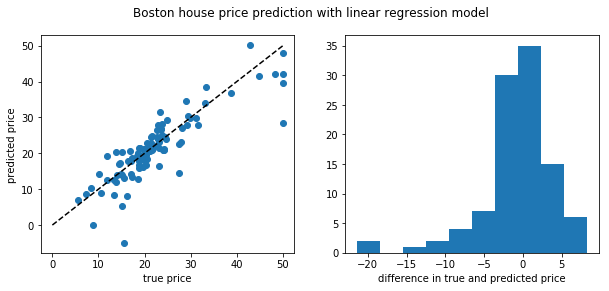

In [23]:
plot_results(y_test,y_pred)

## Add Lasso regularisation

In [24]:
from sklearn.linear_model import Lasso, LassoCV

Test an initial value

In [25]:
model = Lasso(alpha=0.1)

In [26]:
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)

In [27]:
rmse(y_pred, y_test)

4.690786285295981

Grid search a range of alpha values to find the one that gives the lowest rmse

In [28]:
alphas = np.logspace(-3.5, -0.2, 20)

In [29]:
alphas

array([3.16227766e-04, 4.71719914e-04, 7.03669004e-04, 1.04966963e-03,
       1.56580200e-03, 2.33572147e-03, 3.48421754e-03, 5.19743987e-03,
       7.75306963e-03, 1.15653264e-02, 1.72521055e-02, 2.57351270e-02,
       3.83893294e-02, 5.72657215e-02, 8.54238119e-02, 1.27427499e-01,
       1.90084790e-01, 2.83551258e-01, 4.22976062e-01, 6.30957344e-01])

* Had to increase max_iter as low alpha value required more iterations to converge
* cross validation folds = 5

In [30]:
lassocv = LassoCV(alphas=alphas, max_iter=1000000, cv=5, random_state=42)

In [31]:
lassocv.fit(X_train_tr, y_train)

LassoCV(alphas=array([3.16228e-04, 4.71720e-04, 7.03669e-04, 1.04967e-03, 1.56580e-03,
       2.33572e-03, 3.48422e-03, 5.19744e-03, 7.75307e-03, 1.15653e-02,
       1.72521e-02, 2.57351e-02, 3.83893e-02, 5.72657e-02, 8.54238e-02,
       1.27427e-01, 1.90085e-01, 2.83551e-01, 4.22976e-01, 6.30957e-01]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

(2, 5)

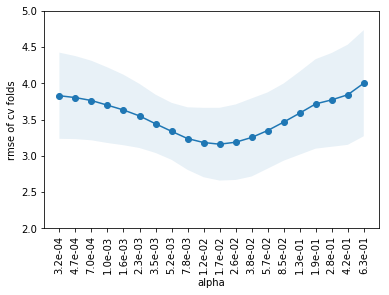

In [32]:
mean_rmses = np.mean(np.sqrt(lassocv.mse_path_), axis=1)
mean_stds = np.std(np.sqrt(lassocv.mse_path_), axis=1)
plt.plot(np.log10(lassocv.alphas_), mean_rmses, '-o')
plt.fill_between(np.log10(lassocv.alphas_), mean_rmses-mean_stds, mean_rmses + mean_stds, alpha=0.1)
plt.xlabel('alpha')
plt.xticks(np.log10(lassocv.alphas_), ['{:.1e}'.format(i) for i in (lassocv.alphas_)], rotation=90)
plt.ylabel('rmse of cv folds')
plt.ylim(2,5)

In [33]:
best_alpha = lassocv.alpha_

In [34]:
best_alpha

0.0172521054994204

Plug in best value to Lasso model

In [35]:
model = Lasso(alpha=best_alpha, max_iter=10000)
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)

In [36]:
rmse(y_test, y_pred)

4.268789419584372

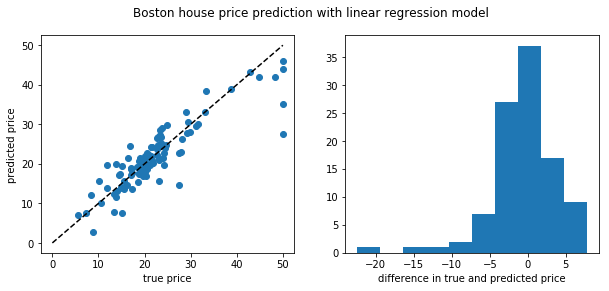

In [37]:
plot_results(y_test, y_pred)

## Feature importances

In [38]:
feat_coefs = pd.DataFrame(data={'feature':X_train_tr.columns, 'coef':model.coef_} )

In [39]:
feat_coefs_reduced = feat_coefs[np.abs(feat_coefs.coef)>1e-5].sort_values('coef')

In [40]:
x = range(len(feat_coefs_reduced))
width = feat_coefs_reduced.coef.values

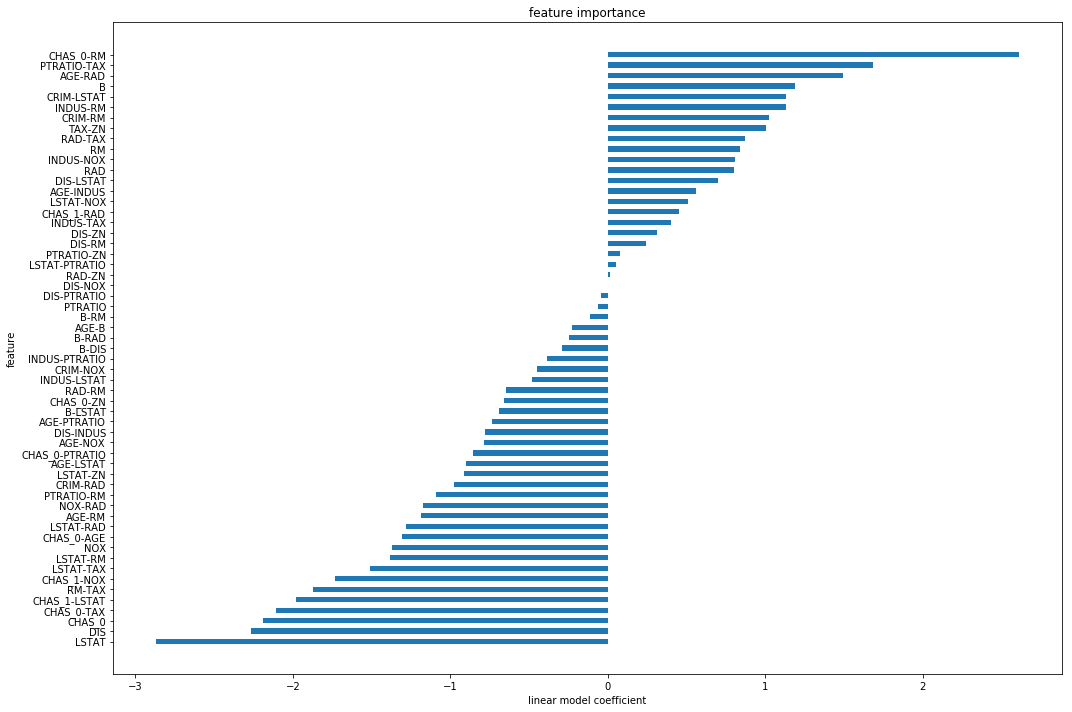

In [41]:
fig = plt.figure(figsize=(15,10))
plt.barh(x, width, height=0.5)
plt.yticks(x, feat_coefs_reduced.feature.values)
plt.ylabel('feature')
plt.xlabel('linear model coefficient')
plt.title('feature importance')
plt.tight_layout()
plt.show()